<a href="https://colab.research.google.com/github/sanuj/tf-basics/blob/master/pretrained_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! wget http://s3.amazonaws.com/text-datasets/aclImdb.zip
! unzip -q aclImdb.zip
! ls

aclImdb  aclImdb.zip  __MACOSX	sample_data


In [0]:
# Processing the labels of the raw IMDB data
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [11]:
# Tokenizing the text of the raw IMDB data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cuts off reviews after 100 words
maxlen = 100
# Trains on 200 samples
training_samples = 200
# Validates on 10,000 samples
validation_samples = 10000
# Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles the data,
# because you’re starting with data in which samples are ordered (all negative first, then
# all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [14]:
# Downloading Glove
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip -q glove.6B.zip

aclImdb      glove.6B.100d.txt	glove.6B.300d.txt  glove.6B.zip  sample_data
aclImdb.zip  glove.6B.200d.txt	glove.6B.50d.txt   __MACOSX


In [15]:
# Parsing the GloVe word-embeddings file
glove_dir = './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    # Words not found in the embedding index will be all zeros.
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [17]:
# Model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.6981 - acc: 0.4700 - val_loss: 0.7173 - val_acc: 0.5052
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5101 - acc: 0.8000 - val_loss: 0.9753 - val_acc: 0.5031
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4398 - acc: 0.8500 - val_loss: 0.6804 - val_acc: 0.5718
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2884 - acc: 0.9700 - val_loss: 0.9993 - val_acc: 0.4979
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3011 - acc: 0.8650 - val_loss: 1.0281 - val_acc: 0.5065
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4359 - acc: 0.7350 - val_loss: 1.2814 - val_acc: 0.5034
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1663 - acc: 0.9450 - val_loss: 0.792

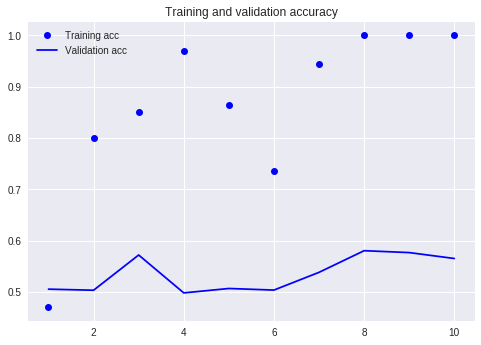

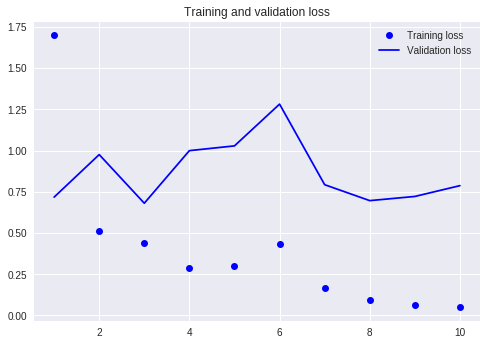

In [18]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Training and evaluation
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()